In [1]:
import pandas as pd
import scipy as sc
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pickle

from operator import truediv, mul

# Data_cleaned

In [2]:
data_cleaned = pd.read_csv("data/data_cleaned.csv")
label = data_cleaned["Categorie1"].values
label_1=[]
label_2=[]
label_3=[]
label_4=[]
label_multi=[]
for k in label:
    if k=="TELEPHONIE - GPS":
        label_1+=[1]
        label_2+=[0]
        label_3+=[0]
        label_4+=[0]
        label_multi+=[k]
    elif k=="INFORMATIQUE":
        label_1+=[0]
        label_2+=[1]
        label_3+=[0]
        label_4+=[0]
        label_multi+=[k]
    elif k=="LIBRAIRIE":
        label_1+=[0]
        label_2+=[0]
        label_3+=[1]
        label_4+=[0]
        label_multi+=[k]
    elif k=="VETEMENTS - LINGERIE " :
        label_1+=[0]
        label_2+=[0]
        label_3+=[0]
        label_4+=[1]
        label_multi+=[k]
    else:
        label_1+=[0]
        label_2+=[0]
        label_3+=[0]
        label_4+=[0]
        label_multi+=["OTHER"]
        
features = sc.sparse.load_npz("data/feature_sparse.npz")

In [3]:
#X:descriptions, Y:categories
X_train, X_test, y_train, y_test = train_test_split(features, label_multi, test_size=0.1, random_state=42)

In [4]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(features, label_1, test_size=0.1, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(features, label_2, test_size=0.1, random_state=42)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(features, label_3, test_size=0.1, random_state=42)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(features, label_4, test_size=0.1, random_state=42)

### Apprentissage par classe:

In [5]:
lr_1= LogisticRegression()
lr_1.fit(X_train_1,y_train_1)
train_score_1 = lr_1.score(X_train_1,y_train_1)
print(train_score_1)

0.9934111111111111


/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
lr_2= LogisticRegression()
lr_2.fit(X_train_2,y_train_2)
train_score_2 = lr_2.score(X_train_2,y_train_2)
print(train_score_2)

0.9930333333333333


/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
lr_3= LogisticRegression()
lr_3.fit(X_train_3,y_train_3)
train_score_3 = lr_3.score(X_train_3,y_train_3)
print(train_score_3)

0.9973222222222222


In [8]:
lr_4= LogisticRegression()
lr_4.fit(X_train_4,y_train_4)
train_score_4 = lr_4.score(X_train_4,y_train_4)
print(train_score_4)

0.9959222222222223


### Apprentissage mutliclasse

In [9]:
ts = time.time()
lr = LogisticRegression()
lr.fit(X_train, y_train)
te = time.time()
print(te-ts, "sec")
train_score = lr.score(X_train,y_train) 
print(train_score) #Nombre de descriptions dont la prédiction est juste/Nombre de descriptions total

6.278723955154419 sec
0.9900111111111111


/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Prediction

In [10]:
predict_1 = lr_1.predict(X_train_1)

In [11]:
predict_2 = lr_2.predict(X_train_2)

In [12]:
predict_3 = lr_3.predict(X_train_3)

In [13]:
predict_4 = lr_4.predict(X_train_4)

In [14]:
predict = lr.predict(X_train)

In [15]:
test_score = lr.score(X_test,y_test)
print("Score multi-class :",test_score, "\n")

print("Scores pour les regressions log binaires : \n")
test_score_1 = lr_1.score(X_test_1,y_test_1)
print("  Score TEL-GPS :",test_score_1, "\n")
test_score_2 = lr_2.score(X_test_2,y_test_2)
print("  Score INFO :",test_score_2, "\n")
test_score_3 = lr_3.score(X_test_3,y_test_3)
print("  Score LIB :",test_score_3, "\n")
#test_score_4 = lr_4.score(X_test_4,y_test_4)
#print("  Score VETEMENTS :",test_score_4, "\n")

Score multi-class : 0.9558 

Scores pour les regressions log binaires : 

  Score TEL-GPS : 0.9876 

  Score INFO : 0.9862 

  Score LIB : 0.9867 



In [16]:
def cross_cat(predictee,trainee):
    pred_cat = predictee==1
    train_cat = np.array(trainee)==1
    TP=0
    FN=0
    FP=0
    TN=0
    cross_tab = pd.crosstab(train_cat, pred_cat, rownames=["Ground True"], colnames=["Prediction"])
    #cross_tab = A.divide(A.sum(axis=1),axis=0)*100
    print(cross_tab)
    TP=cross_tab[1][1] #ok
    FN=cross_tab[0][1]
    FP=cross_tab[1][0]
    TN=cross_tab[0][0] #ok
    return len(trainee),TP,FN,FP,TN

In [17]:
nb_data_1,TP_1,FN_1,FP_1,TN_1=cross_cat(predict_1,y_train_1)
nb_data_2,TP_2,FN_2,FP_2,TN_2=cross_cat(predict_2,y_train_2)
nb_data_3,TP_3,FN_3,FP_3,TN_3=cross_cat(predict_3,y_train_3)
#nb_data_4,TP_4,FN_4,FP_4,TN_4=cross_cat(predict_4,y_train_4)

#cat= ["TELEPHONIE - GPS","INFORMATIQUE","LIBRAIRIE","VETEMENTS - LINGERIE "]
#TP =[TP_1,TP_2,TP_3,TP_4]  #Vrai predit Vrai
#TN = [TN_1,TN_2,TN_3,TN_4] #Faux predit faux

cat= ["TELEPHONIE - GPS","LIBRAIRIE"]
TP =[TP_1,TP_3]  #Vrai predit Vrai
TN = [TN_1,TN_3] #Faux predit faux


#FP = [FP_1,FP_2,FP_3,FP_4] #Faux predit Vrai
#FN = [FN_1,FN_2,FN_3,FN_4] #Vrai predit faux

FP = [FP_1,FP_3] #Faux predit Vrai
FN = [FN_1,FN_3] #Vrai predit faux

Prediction   False  True 
Ground True              
False        70642    185
True           408  18765
Prediction   False  True 
Ground True              
False        76656    160
True           467  12717
Prediction   False  True 
Ground True              
False        78938    165
True            76  10821


In [18]:
#à comparer avec l'apprentissage sur toutes les classes !

for cat_name in cat :
    predict_cat = predict==cat_name
    y_train_cat = np.array(y_train)==cat_name
    cross_tab = pd.crosstab(y_train_cat, predict_cat, rownames=["Ground True"], colnames=["Prediction"])
    #cross_tab = A.divide(A.sum(axis=1),axis=0)*100
    print(cross_tab, '\n')
    TP += [cross_tab[1][1]]
    FP += [cross_tab[1][0]]
    TN += [cross_tab[0][0]]
    FN += [cross_tab[0][1]]

Prediction   False  True 
Ground True              
False        70634    193
True           170  19003 

Prediction   False  True 
Ground True              
False        78950    153
True            32  10865 



In [19]:
PFP=np.zeros(len(FP)) 
PFN=np.zeros(len(FN)) 
err=np.zeros(len(TP)) 
err2=np.zeros(len(TP)) 
for i in range(len(TP)) : 
    PFP[i] = FP[i]/(FP[i]+TN[i])*100
    PFN[i] = FN[i]/(FN[i]+TP[i])*100 
    err2[i] = (FN[i]+FP[i])/90000 * 100
    
#cat = ["TELEPHONIE - GPS","INFORMATIQUE","LIBRAIRIE","VETEMENTS - LINGERIE ","GPS_mul","INFO_mul","LIB_mul","VET_mul"]
cat = ["TEL-GPS binary","LIBRAIRIE binary","TEL-GPS multi","LIB multi"]

In [20]:
print(err2)

[0.65888889 0.26777778 0.40333333 0.20555556]


In [21]:
def bar_plot_false(cat,PFN,PFP):
    fig = plt.figure(figsize=(5,5))
    plt.bar(cat,PFP,width = 0.4, color = 'blue', label="false positive rate")
    plt.bar(cat,PFN,width = 0.4, color = 'orange', label="false negative rate")
    plt.legend()
    fig.autofmt_xdate(rotation=45)

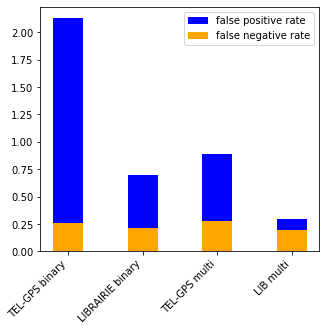

In [22]:
bar_plot_false(cat,PFP,PFN)

In [23]:
def bar_plot_error(cat,err):
    fig = plt.figure(figsize=(5,5))
    plt.bar(cat,err,width = 0.4, color = 'green', label="error rate")
    #plt.title("Erreur de prediction")
    plt.legend()
    fig.autofmt_xdate(rotation=45)

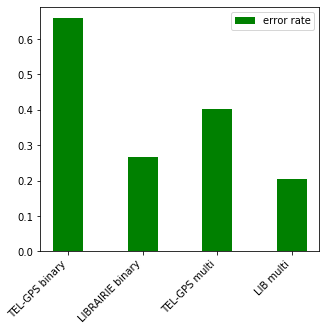

In [24]:
bar_plot_error(cat,err2)

### Comments : 

* Pour les regressions binaires, chaque regresseur est independant des autres ainsi un objet peut etre classé dans une catégorie A pour une regressif mais etgalement dans une categorie B pour une autre regression.
* ie, un produit d'informatique peut etre classé comme appartenant a cette catégorie lorsque qu'on fait la regression binaire sur INFO cependant ce meme produit peu etre classé comme appartenant à GPS quand on fait la regression sur la categorie GPS, dès lors il contribue au taux de faux positifs de la catégorie GPS.


* En regression multinomiale, toutes les catégories sont traitées en meme temps donc un produit ne peut etre classé que dans 1 seule catégorie. 
* ie, un faux positif d'une catégorie A va forcément augmenter le taux de faux négatif de B (avec B la véritable catégorie du produit).


## Reduction X train

In [25]:
def X_reduction(train_size, name_cat, features) :
    score_list=[]
    score_vect=[]
    TP = []
    FP = []
    TN = []
    FN = []
    data_train = []
    X_train, X_test, y_train, y_test = train_test_split(features, label_multi, test_size=0.1, random_state=42)
    for i in range(len(train_size)) :
        X_red = X_train[0:train_size[i]] 
        y_red = y_train[0:train_size[i]]
        
        data_cat = np.array(y_red)==name_cat #compte nb d'éléments appartenants à la cat dans l'échantillon d'apprentissage
        data_train += [np.sum(data_cat)]
        
        lr = LogisticRegression()
        lr.fit(X_red, y_red)
        predict=lr.predict(X_test)
        predict_cat = predict==name_cat
        y_test_cat = np.array(y_test)==name_cat 
        cross_tab = pd.crosstab(y_test_cat, predict_cat, rownames=["Ground True"], colnames=["Prediction"])
        score= sum(np.diag(cross_tab))/sum(cross_tab.sum())
        score_list.append([score,len(y_red)]) #ajout score + nb de données d'apprentissage
        score_vect.append(score)
        TP += [cross_tab[1][1]]
        FP += [cross_tab[1][0]]
        TN += [cross_tab[0][0]]
        FN += [cross_tab[0][1]]
    return score_list, score_vect, FP, FN, data_train

### Telephonie - GPS

In [26]:
train_size = [100,200,500,700,1000,1500,2500,3500,5000,7500,10000,25000,40000,60000,90000]
features_bow = sc.sparse.load_npz("data/feature_sparse.npz")
A,B,FP_bow,FN_bow,data_tel = X_reduction(train_size,"TELEPHONIE - GPS", features_bow)

with open("features1M_word2vec.txt", "rb") as fp:   # Unpickling
    features1M_word2vec = pickle.load(fp)
C,D,FP_1M,FN_1M,data_tel = X_reduction(train_size,"TELEPHONIE - GPS", features1M_word2vec[:100000])

with open("features100k_word2vec.txt", "rb") as fp:   # Unpickling
    features100k_word2vec = pickle.load(fp)
E,F,FP_100k,FN_100k,data_tel = X_reduction(train_size,"TELEPHONIE - GPS", features100k_word2vec)

/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

In [27]:
print(data_tel)

[24, 47, 112, 161, 234, 338, 553, 780, 1113, 1653, 2149, 5396, 8657, 12781, 19173]


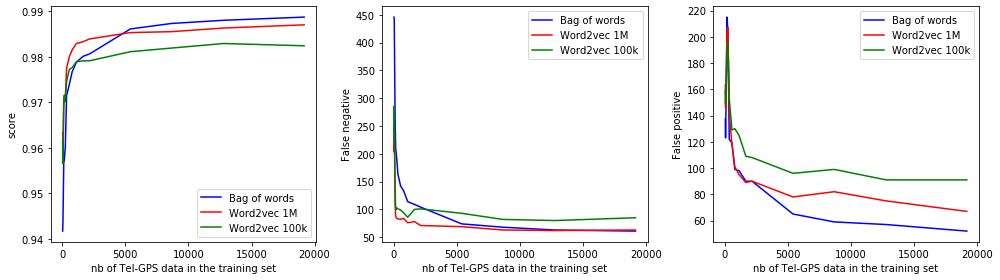

In [28]:
plt.figure(figsize=(14,4))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.5, hspace = 0.2)
plt.subplot(1, 3, 1)
plt.plot(data_tel,B,"b", label="Bag of words")
plt.plot(data_tel,D,"r", label="Word2vec 1M")
plt.plot(data_tel,F,"g", label="Word2vec 100k")
plt.xlabel("nb of Tel-GPS data in the training set")
plt.ylabel("score")
plt.legend()


plt.subplot(1, 3, 2)
plt.plot(data_tel,FN_bow,"b", label="Bag of words")
plt.plot(data_tel,FN_1M,"r", label="Word2vec 1M")
plt.plot(data_tel,FN_100k,"g", label="Word2vec 100k")
plt.xlabel("nb of Tel-GPS data in the training set")
plt.ylabel("False negative")
plt.legend()


plt.subplot(1, 3, 3)
plt.plot(data_tel,FP_bow,"b", label="Bag of words")
plt.plot(data_tel,FP_1M,"r", label="Word2vec 1M")
plt.plot(data_tel,FP_100k,"g", label="Word2vec 100k")
plt.xlabel("nb of Tel-GPS data in the training set")
plt.ylabel("False positive")
plt.legend()
plt.tight_layout()

### Librairie

In [29]:
train_size = [100,200,500,700,1000,1500,2500,3500,5000,7500,10000,25000,40000,60000,90000]
features_bow = sc.sparse.load_npz("data/feature_sparse.npz")
A,B,FP_bow,FN_bow,data_lib = X_reduction(train_size,"LIBRAIRIE", features_bow)

with open("features1M_word2vec.txt", "rb") as fp:   # Unpickling
    features1M_word2vec = pickle.load(fp)
C,D,FP_1M,FN_1M,data_lib = X_reduction(train_size,"LIBRAIRIE", features1M_word2vec[:100000])

with open("features100k_word2vec.txt", "rb") as fp:   # Unpickling
    features100k_word2vec = pickle.load(fp)
E,F,FP_100k,FN_100k,data_lib = X_reduction(train_size,"LIBRAIRIE", features100k_word2vec)

/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

In [30]:
print(data_lib)

[11, 23, 61, 79, 110, 164, 283, 404, 594, 900, 1232, 3029, 4874, 7324, 10897]


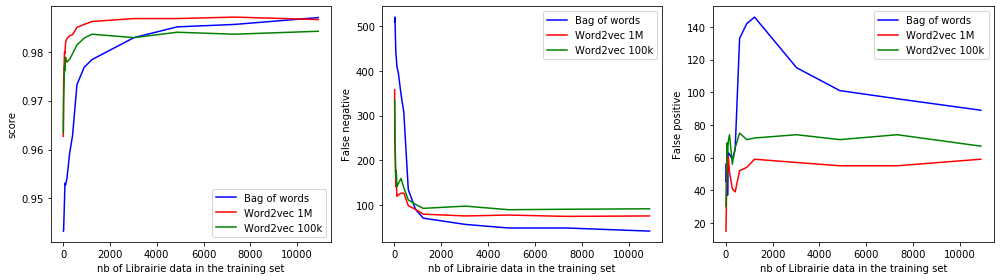

In [31]:
plt.figure(figsize=(14,4))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.5, hspace = 0.2)
plt.subplot(1, 3, 1)
plt.plot(data_lib,B,"b", label="Bag of words")
plt.plot(data_lib,D,"r", label="Word2vec 1M")
plt.plot(data_lib,F,"g", label="Word2vec 100k")
plt.xlabel("nb of Librairie data in the training set")
plt.ylabel("score")
plt.legend()


plt.subplot(1, 3, 2)
plt.plot(data_lib,FN_bow,"b", label="Bag of words")
plt.plot(data_lib,FN_1M,"r", label="Word2vec 1M")
plt.plot(data_lib,FN_100k,"g", label="Word2vec 100k")
plt.xlabel("nb of Librairie data in the training set")
plt.ylabel("False negative")
plt.legend()


plt.subplot(1, 3, 3)
plt.plot(data_lib,FP_bow,"b", label="Bag of words")
plt.plot(data_lib,FP_1M,"r", label="Word2vec 1M")
plt.plot(data_lib,FP_100k,"g", label="Word2vec 100k")
plt.xlabel("nb of Librairie data in the training set")
plt.ylabel("False positive")
plt.legend()
plt.tight_layout()

* forte diversité de vocabulaire, word2vec deja très bon dès 1000 données d'apprentissage
* gain de temps car palie au manque de données non labelisées

### Informatique

In [32]:
train_size = [100,200,500,700,1000,1500,2500,3500,5000,7500,10000,25000,40000,60000,90000]
features_bow = sc.sparse.load_npz("data/feature_sparse.npz")
A,B,FP_bow,FN_bow,data_info = X_reduction(train_size,"INFORMATIQUE", features_bow)

with open("features1M_word2vec.txt", "rb") as fp:   # Unpickling
    features1M_word2vec = pickle.load(fp)
C,D,FP_1M,FN_1M,data_info = X_reduction(train_size,"INFORMATIQUE", features1M_word2vec[:100000])

with open("features100k_word2vec.txt", "rb") as fp:   # Unpickling
    features100k_word2vec = pickle.load(fp)
E,F,FP_100k,FN_100k,data_info = X_reduction(train_size,"INFORMATIQUE", features100k_word2vec)

/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

In [33]:
print(data_info)

[16, 34, 72, 99, 140, 228, 366, 507, 702, 1057, 1446, 3654, 5781, 8743, 13184]


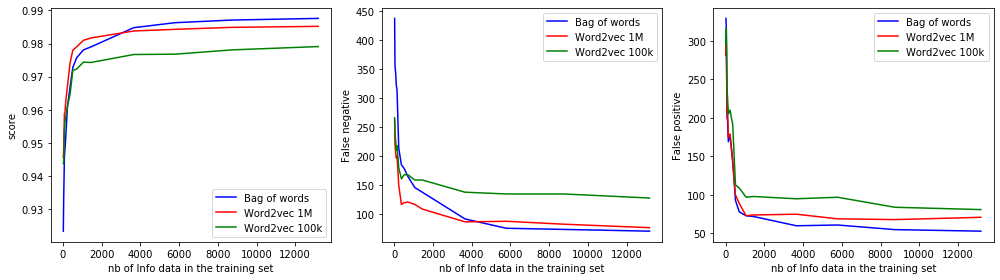

In [34]:
plt.figure(figsize=(14,4))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.1, right = 0.9, top = 0.9, wspace = 0.5, hspace = 0.2)
plt.subplot(1, 3, 1)
plt.plot(data_info,B,"b", label="Bag of words")
plt.plot(data_info,D,"r", label="Word2vec 1M")
plt.plot(data_info,F,"g", label="Word2vec 100k")
plt.xlabel("nb of Info data in the training set")
plt.ylabel("score")
plt.legend()


plt.subplot(1, 3, 2)
plt.plot(data_info,FN_bow,"b", label="Bag of words")
plt.plot(data_info,FN_1M,"r", label="Word2vec 1M")
plt.plot(data_info,FN_100k,"g", label="Word2vec 100k")
plt.xlabel("nb of Info data in the training set")
plt.ylabel("False negative")
plt.legend()


plt.subplot(1, 3, 3)
plt.plot(data_info,FP_bow,"b", label="Bag of words")
plt.plot(data_info,FP_1M,"r", label="Word2vec 1M")
plt.plot(data_info,FP_100k,"g", label="Word2vec 100k")
plt.xlabel("nb of Info data in the training set")
plt.ylabel("False positive")
plt.legend()
plt.tight_layout()